# I. Implémentation de trois méthodes de Frequent Itemset Generation

## 1. 1

Nous avons implémenté trois méthode de l'algorithme Apriori pour la génération des itemsets fréquents. Les trois méthodes sont les suivantes :
 
- Brute-force : génère tous les k-itemsets possibles à chaque itération
- F_{k-1} x F_1 : génère les candidats Ck en combinant les itemsets fréquents de taille k-1 avec les itemsets fréquents de taille 1
- F_{k-1} x F_{k-1} : génère les candidats Ck en combinant les itemsets fréquents de taille k-1 avec eux-mêmes


In [6]:
import random
import time
from itertools import combinations


class Apriori:
    def __init__(self, transactions, minsup, method=3, verbose=True):
        """
        Initialise l'algorithme Apriori avec les paramètres fournis.

        Paramètres
        ----------
        transactions : list of list
            Liste des transactions, chaque transaction étant une liste d'items (chaînes de caractères, par exemple).
        minsup : float
            Seuil minimal de support, exprimé en fraction du nombre total de transactions.
        method : int, optionnel
            Méthode de génération des candidats. Les valeurs possibles sont :
            1 : Brute force (génère tous les k-itemsets possibles à chaque itération)
            2 : F_{k-1} x F_1
            3 : F_{k-1} x F_{k-1}
            Par défaut, method=3.
        verbose : bool, optionnel
            Si True, affiche le détail des étapes (itemsets générés, fréquences, etc.).
            Par défaut, True.
        """
        self.transactions = transactions
        self.minsup = minsup
        self.method = method
        self.verbose = verbose

        self.nb_transactions = len(transactions)
        self.min_count = int(self.minsup * self.nb_transactions)
        self.items = sorted(set(i for t in transactions for i in t))

        # Pour stocker les résultats par niveau k
        self.results_by_k = {}
        # Notre Ensemble pour mémoriser les itemsets infrequents
        self.known_infrequent = set()

        # Association du numéro de méthode à un nom
        if self.method == 1:
            self.method_name = "Brute-force"
        elif self.method == 2:
            self.method_name = "F_{k-1} x F_1"
        elif self.method == 3:
            self.method_name = "F_{k-1} x F_{k-1}"
        else:
            raise ValueError("Méthode inconnue. Choisissez 1, 2, ou 3.")

    def support_count(self, itemset):
        """
        Calcule le nombre de transactions contenant tous les items de 'itemset'.
        """
        s = set(itemset)
        return sum(1 for tr in self.transactions if s.issubset(tr))

    def is_infrequent_subset(self, itmset):
        """
        Vérifie si le k-itemset 'itmset' contient un (k-1)-itemset déjà connu comme infrequent.
        """
        k = len(itmset)
        if k == 1:
            return False
        for sub in combinations(itmset, k - 1):
            if frozenset(sub) in self.known_infrequent:
                return True
        return False

    def print_results(self):
        """
        Affiche les résultats par niveau k.
        """
        print(f"Méthode {self.method_name}")
        for k in sorted(self.results_by_k.keys()):
            print(f"{k}-itemsets")
            r = sorted(self.results_by_k[k], key=lambda x: x[0])
            for itm, sc, st in r:
                itm_str = ",".join(itm)
                if st == 'N':
                    # 'N' : itemset écarté car contenant un sous-ensemble infrequent
                    print(f"{itm_str} {st}")
                else:
                    if st == 'F':
                        # Affichage itemset fréquent
                        print(f"{itm_str} {sc} {st}")
                    else:
                        # st == 'I' : itemset infrequent
                        print(f"{itm_str} {sc} {st}")
            print("==========================")

    def run(self):
        """
        Exécute l'algorithme Apriori pour extraire les itemsets fréquents.

        Retour
        ------
        frequent_itemsets : list of tuples
            Liste des itemsets fréquents sous la forme (itemset, support) avec support en fraction.
        """
        # Génération des 1-itemsets fréquents (F1)
        k = 1
        c1 = [(i,) for i in self.items]
        r1 = []
        for itm in c1:
            sc = self.support_count(itm)
            if sc >= self.min_count:
                r1.append((itm, sc, 'F'))
            else:
                r1.append((itm, sc, 'I'))
                self.known_infrequent.add(frozenset(itm))
        self.results_by_k[1] = r1

        # calcul des premier itemset fréquent si la méthode est 2
        if self.method == 2:
            f1 = [itm for itm, sc, st in self.results_by_k[1] if st == 'F']

        # Boucle principale
        while True:
            fk = [itm for itm, sc, st in self.results_by_k[k] if st == 'F']

            if not fk:
                break

            k += 1
            # Génération des candidats Ck selon la méthode
            if self.method == 1:
                # Brute force : toutes les combinaisons de taille k
                all_candidates = list(combinations(self.items, k))
            elif self.method == 2:
                # F_{k-1} x F_1
                candidate_sets = set()
                for a in fk:
                    for b in f1:
                        newset = frozenset(a).union(b)
                        if len(newset) == k:
                            candidate_sets.add(tuple(sorted(newset)))
                all_candidates = list(candidate_sets)
            elif self.method == 3:
                # F_{k-1} x F_{k-1}
                candidate_sets = set()
                for a in fk:
                    for b in fk:
                        newset = frozenset(a).union(b)
                        if len(newset) == k:
                            candidate_sets.add(tuple(sorted(newset)))
                all_candidates = list(candidate_sets)

            # Pruning
            pruned = [c for c in all_candidates if self.is_infrequent_subset(c)]
            candidates = [c for c in all_candidates if not self.is_infrequent_subset(c)]

            rk = []
            if self.verbose :
            # Candidats prunés
                for p in pruned:
                    rk.append((p, None, 'N'))
                    self.known_infrequent.add(frozenset(p))
    
                # Évaluation des candidats restants
                for c in candidates:
                    sc = self.support_count(c)
                    if sc >= self.min_count:
                        rk.append((c, sc, 'F'))
                    else:
                        rk.append((c, sc, 'I'))
                        self.known_infrequent.add(frozenset(c))

                self.results_by_k[k] = rk

            # Si aucun fréquent, on arrête
            if not any(st == 'F' for itm, sc, st in rk):
                break

        # Affichage si demandé
        if self.verbose:
            self.print_results()

        # Préparer la liste des itemsets fréquents avec support relatif
        frequent_itemsets = []
        for k in self.results_by_k:
            for itm, sc, st in self.results_by_k[k]:
                if st == 'F':
                    frequent_itemsets.append((itm, sc / self.nb_transactions))
        return frequent_itemsets

    # fonction pour générer des transactions aléatoires pour la question 2.1
    @staticmethod
    def generateTransaction(nbTransaction, nbItems, intervalle):
        MyCaseChoice = [f"p{i}" for i in range(nbItems)]
        transactions = []
        for _ in range(nbTransaction):
            currentNbItems = random.randint(intervalle[0], intervalle[1])
            items = random.sample(MyCaseChoice, currentNbItems)
            transactions.append(items)
        return transactions
    
    # fonction pour comparer la performance de nos 3 algos pour la question 2.2
    @staticmethod
    def plot_comparison(transactions_sizes, times_brute, times_fkm1f1, times_fkm1fk1):
        """
        Affiche un graphique comparant les trois méthodes (Brute-force, F_{k-1} x F_1, F_{k-1} x F_{k-1})
        en fonction du temps d'exécution moyen obtenu.
        """
        import matplotlib.pyplot as plt

        plt.figure(figsize=(8, 4))
        plt.plot(transactions_sizes, times_brute, marker='o', label='Brute-Force')
        plt.plot(transactions_sizes, times_fkm1f1, marker='x', label='F_{k-1} x F_1')
        plt.plot(transactions_sizes, times_fkm1fk1, marker='s', label='F_{k-1} x F_{k-1}')
        plt.grid(True)

        plt.xlabel('Nombre de transactions')
        plt.ylabel('Temps (secondes)')
        plt.title('Comparaison des méthodes Apriori')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # fonction pour comparer la performance de l'algo F_{k-1} x F_{k-1} , Spark et Mlxtend our la question 3.2
    @staticmethod
    def plot_comparison2(transactions_sizes, times_fkm1fk1, times_spark, times_mxltend):
        """
        Affiche un graphique comparant les trois méthodes (Spark, Mlxtend, F_{k-1} x F_{k-1})
        en fonction du temps d'exécution moyen obtenu.
        """
        import matplotlib.pyplot as plt

        plt.figure(figsize=(8, 4))
        plt.plot(transactions_sizes, times_fkm1fk1, marker='o', label='F_{k-1} x F_{k-1}')
        plt.plot(transactions_sizes, times_spark, marker='x', label='Spark')
        plt.plot(transactions_sizes, times_mxltend, marker='s', label='Mlxtend')
        plt.grid(True)

        plt.xlabel('Nombre de transactions')
        plt.ylabel('Temps (secondes)')
        plt.title('Comparaison des méthodes Apriori')
        plt.legend()
        plt.grid(True)
        plt.show()


La différence entre ces trois méthodes réside dans la manière dont les candidats Ck sont générés à partir des itemsets fréquents de l'itération k-1. La méthode brute-force génère tous les k-itemsets possibles à chaque itération, sans prendre en compte l'itération précédente, tandis que les deux autres méthodes utilisent les itemsets fréquents de taille k-1 pour générer les candidats Ck. La méthode F_{k-1} x F_1 combine les itemsets fréquents de l'itération k-1 avec les itemsets fréquents de la première itération, tandis que la méthode F_{k-1} x F_{k-1} combine les itemsets fréquents de l'itération k-1 avec eux même. L'objectif des deux dernières méthodes est de réduire le nombre de candidats à évaluer à chaque itération, en évitant de générer des itemsets qui ont déjà été identifiés comme infrequents, qui ne seront pas acceptés. On ne joue pas sur la complexité de l'algorithme mais sur le nombre de candidats à évaluer.


## 1.2 Tests des 3 méthodes avec les jeux de données fournis
### Utilisation des transactions Bread, Milk, Beer, Eggs, Diapers, Coke

In [3]:
 # Exemple d'utilisation
transactions = [
    ["Bread", "Milk"],
    ["Bread", "Diapers", "Beer", "Eggs"],
    ["Milk", "Diapers", "Beer", "Coke"],
    ["Bread", "Milk", "Diapers", "Beer"],
    ["Bread", "Milk", "Diapers", "Coke"]
]
minsup = 0.6

print("==========================")
print("Test brute-force for minsup=0.6")
print("==========================")
apriori_bf = Apriori(transactions, minsup, method=1, verbose=True)
freq_bf = apriori_bf.run()
print("Fréquents (brute-force):", freq_bf)

print("==========================")
print("Test F_{k-1} x F_1 for minsup=0.6")
print("==========================")
apriori_f1 = Apriori(transactions, minsup, method=2, verbose=True)
freq_f1 = apriori_f1.run()
print("Fréquents (F_{k-1} x F_1):", freq_f1)

print("==========================")
print("Test F_{k-1} x F_{k-1} for minsup=0.6")
print("==========================")
apriori_ff = Apriori(transactions, minsup, method=3, verbose=True)
freq_ff = apriori_ff.run()
print("Fréquents (F_{k-1} x F_{k-1}):", freq_ff)

Test brute-force for minsup=0.6
Méthode Brute-force
1-itemsets
Beer 3 F
Bread 4 F
Coke 2 I
Diapers 4 F
Eggs 1 I
Milk 4 F
2-itemsets
Beer,Bread 2 I
Beer,Coke N
Beer,Diapers 3 F
Beer,Eggs N
Beer,Milk 2 I
Bread,Coke N
Bread,Diapers 3 F
Bread,Eggs N
Bread,Milk 3 F
Coke,Diapers N
Coke,Eggs N
Coke,Milk N
Diapers,Eggs N
Diapers,Milk 3 F
Eggs,Milk N
3-itemsets
Beer,Bread,Coke N
Beer,Bread,Diapers N
Beer,Bread,Eggs N
Beer,Bread,Milk N
Beer,Coke,Diapers N
Beer,Coke,Eggs N
Beer,Coke,Milk N
Beer,Diapers,Eggs N
Beer,Diapers,Milk N
Beer,Eggs,Milk N
Bread,Coke,Diapers N
Bread,Coke,Eggs N
Bread,Coke,Milk N
Bread,Diapers,Eggs N
Bread,Diapers,Milk 2 I
Bread,Eggs,Milk N
Coke,Diapers,Eggs N
Coke,Diapers,Milk N
Coke,Eggs,Milk N
Diapers,Eggs,Milk N
Fréquents (brute-force): [(('Beer',), 0.6), (('Bread',), 0.8), (('Diapers',), 0.8), (('Milk',), 0.8), (('Beer', 'Diapers'), 0.6), (('Bread', 'Diapers'), 0.6), (('Bread', 'Milk'), 0.6), (('Diapers', 'Milk'), 0.6)]
Test F_{k-1} x F_1 for minsup=0.6
Méthode F_{k-1} 

## 1.3 Tests des 3 méthodes avec abcde 

### Test méthode brutforce avec transaction_a et minsup=0.3


In [5]:
transactions_a = [
    ["a", "b", "d", "e"],
    ["b", "c", "d"],
    ["a", "b", "d", "e"],
    ["a", "c", "d", "e"],
    ["b", "c", "d", "e"],
    ["b", "d", "e"],
    ["c", "d"],
    ["a", "b", "c"],
    ["a", "d", "e"],
    ["b", "d"]
]
minsup_a = 0.3

print("==========================")
print("Test brute-force for a with minsup=0.3")
print("==========================")
apriori_a_brute = Apriori(transactions_a, minsup_a, method=1, verbose=True)
freq_a_brute = apriori_a_brute.run()
print("Fréquents (jeu a, Brute-force):", freq_a_brute)

Test brute-force for a with minsup=0.3
Méthode Brute-force
1-itemsets
a 5 F
b 7 F
c 5 F
d 9 F
e 6 F
2-itemsets
a,b 3 F
a,c 2 I
a,d 4 F
a,e 4 F
b,c 3 F
b,d 6 F
b,e 4 F
c,d 4 F
c,e 2 I
d,e 6 F
3-itemsets
a,b,c N
a,b,d 2 I
a,b,e 2 I
a,c,d N
a,c,e N
a,d,e 4 F
b,c,d 2 I
b,c,e N
b,d,e 4 F
c,d,e N
4-itemsets
a,b,c,d N
a,b,c,e N
a,b,d,e N
a,c,d,e N
b,c,d,e N
Fréquents (jeu a, Brute-force): [(('a',), 0.5), (('b',), 0.7), (('c',), 0.5), (('d',), 0.9), (('e',), 0.6), (('a', 'b'), 0.3), (('a', 'd'), 0.4), (('a', 'e'), 0.4), (('b', 'c'), 0.3), (('b', 'd'), 0.6), (('b', 'e'), 0.4), (('c', 'd'), 0.4), (('d', 'e'), 0.6), (('a', 'd', 'e'), 0.4), (('b', 'd', 'e'), 0.4)]


### Test méthode F_{k-1} x F_1 avec transaction_a et minsup=0.3


In [6]:
print("==========================")
print("test F_{k-1} x F_1 for a with minsup=0.3")
print("==========================")
apriori_a_fkm1f1 = Apriori(transactions_a, minsup_a, method=2, verbose=True)
freq_a_fkm1f1 = apriori_a_fkm1f1.run()
print("Fréquents (jeu a, F_{k-1} x F_1):", freq_a_fkm1f1)

test F_{k-1} x F_1 for a with minsup=0.3
Méthode F_{k-1} x F_1
1-itemsets
a 5 F
b 7 F
c 5 F
d 9 F
e 6 F
2-itemsets
a,b 3 F
a,c 2 I
a,d 4 F
a,e 4 F
b,c 3 F
b,d 6 F
b,e 4 F
c,d 4 F
c,e 2 I
d,e 6 F
3-itemsets
a,b,c N
a,b,d 2 I
a,b,e 2 I
a,c,d N
a,c,e N
a,d,e 4 F
b,c,d 2 I
b,c,e N
b,d,e 4 F
c,d,e N
4-itemsets
a,b,d,e N
a,c,d,e N
b,c,d,e N
Fréquents (jeu a, F_{k-1} x F_1): [(('a',), 0.5), (('b',), 0.7), (('c',), 0.5), (('d',), 0.9), (('e',), 0.6), (('b', 'e'), 0.4), (('b', 'c'), 0.3), (('a', 'e'), 0.4), (('d', 'e'), 0.6), (('c', 'd'), 0.4), (('a', 'd'), 0.4), (('a', 'b'), 0.3), (('b', 'd'), 0.6), (('b', 'd', 'e'), 0.4), (('a', 'd', 'e'), 0.4)]


## Test méthode  F_{k-1} x F_{k-1} avec transaction_a et minsup=0.3


In [7]:

print("==========================")
print("test F_{k-1} x F_{k-1} for a with minsup=0.3")
print("==========================")
apriori_a_fkm1fk1 = Apriori(transactions_a, minsup_a, method=3, verbose=True)
freq_a_fkm1fk1 = apriori_a_fkm1fk1.run()
print("Fréquents (jeu a, F_{k-1} x F_{k-1}):", freq_a_fkm1fk1)


test F_{k-1} x F_{k-1} for a with minsup=0.3
Méthode F_{k-1} x F_{k-1}
1-itemsets
a 5 F
b 7 F
c 5 F
d 9 F
e 6 F
2-itemsets
a,b 3 F
a,c 2 I
a,d 4 F
a,e 4 F
b,c 3 F
b,d 6 F
b,e 4 F
c,d 4 F
c,e 2 I
d,e 6 F
3-itemsets
a,b,c N
a,b,d 2 I
a,b,e 2 I
a,c,d N
a,d,e 4 F
b,c,d 2 I
b,c,e N
b,d,e 4 F
c,d,e N
4-itemsets
a,b,d,e N
Fréquents (jeu a, F_{k-1} x F_{k-1}): [(('a',), 0.5), (('b',), 0.7), (('c',), 0.5), (('d',), 0.9), (('e',), 0.6), (('b', 'e'), 0.4), (('b', 'c'), 0.3), (('a', 'e'), 0.4), (('d', 'e'), 0.6), (('c', 'd'), 0.4), (('a', 'd'), 0.4), (('a', 'b'), 0.3), (('b', 'd'), 0.6), (('b', 'd', 'e'), 0.4), (('a', 'd', 'e'), 0.4)]


## Test méthode brutforce avec transaction_b et minsup=0.5


In [8]:
transactions_b = [
    ["b", "c", "d"],
    ["a", "b", "c", "d", "e"],
    ["a", "b", "c", "e"],
    ["a", "b", "d", "e"],
    ["b", "c", "e"],
    ["a", "b", "d", "e"]
]
minsup_b = 0.5

print("==========================")
print("test brute-force for b with minsup=0.5")
print("==========================")
apriori_b_brute = Apriori(transactions_b, minsup_b, method=1, verbose=True)
freq_b_brute = apriori_b_brute.run()
print("Fréquents (jeu b, Brute-force):", freq_b_brute)

test brute-force for b with minsup=0.5
Méthode Brute-force
1-itemsets
a 4 F
b 6 F
c 4 F
d 4 F
e 5 F
2-itemsets
a,b 4 F
a,c 2 I
a,d 3 F
a,e 4 F
b,c 4 F
b,d 4 F
b,e 5 F
c,d 2 I
c,e 3 F
d,e 3 F
3-itemsets
a,b,c N
a,b,d 3 F
a,b,e 4 F
a,c,d N
a,c,e N
a,d,e 3 F
b,c,d N
b,c,e 3 F
b,d,e 3 F
c,d,e N
4-itemsets
a,b,c,d N
a,b,c,e N
a,b,d,e 3 F
a,c,d,e N
b,c,d,e N
5-itemsets
a,b,c,d,e N
Fréquents (jeu b, Brute-force): [(('a',), 0.6666666666666666), (('b',), 1.0), (('c',), 0.6666666666666666), (('d',), 0.6666666666666666), (('e',), 0.8333333333333334), (('a', 'b'), 0.6666666666666666), (('a', 'd'), 0.5), (('a', 'e'), 0.6666666666666666), (('b', 'c'), 0.6666666666666666), (('b', 'd'), 0.6666666666666666), (('b', 'e'), 0.8333333333333334), (('c', 'e'), 0.5), (('d', 'e'), 0.5), (('a', 'b', 'd'), 0.5), (('a', 'b', 'e'), 0.6666666666666666), (('a', 'd', 'e'), 0.5), (('b', 'c', 'e'), 0.5), (('b', 'd', 'e'), 0.5), (('a', 'b', 'd', 'e'), 0.5)]


## Test méthode F_{k-1} x F_1 avec transaction_b et minsup=0.5


In [9]:
print("==========================")
print("test F_{k-1} x F_1 for b with minsup=0.5")
print("==========================")
apriori_b_fkm1f1 = Apriori(transactions_b, minsup_b, method=2, verbose=True)
freq_b_fkm1f1 = apriori_b_fkm1f1.run()
print("Fréquents (jeu b, F_{k-1} x F_1):", freq_b_fkm1f1)

test F_{k-1} x F_1 for b with minsup=0.5
Méthode F_{k-1} x F_1
1-itemsets
a 4 F
b 6 F
c 4 F
d 4 F
e 5 F
2-itemsets
a,b 4 F
a,c 2 I
a,d 3 F
a,e 4 F
b,c 4 F
b,d 4 F
b,e 5 F
c,d 2 I
c,e 3 F
d,e 3 F
3-itemsets
a,b,c N
a,b,d 3 F
a,b,e 4 F
a,c,d N
a,c,e N
a,d,e 3 F
b,c,d N
b,c,e 3 F
b,d,e 3 F
c,d,e N
4-itemsets
a,b,c,d N
a,b,c,e N
a,b,d,e 3 F
a,c,d,e N
b,c,d,e N
5-itemsets
a,b,c,d,e N
Fréquents (jeu b, F_{k-1} x F_1): [(('a',), 0.6666666666666666), (('b',), 1.0), (('c',), 0.6666666666666666), (('d',), 0.6666666666666666), (('e',), 0.8333333333333334), (('b', 'e'), 0.8333333333333334), (('b', 'c'), 0.6666666666666666), (('a', 'e'), 0.6666666666666666), (('d', 'e'), 0.5), (('a', 'd'), 0.5), (('a', 'b'), 0.6666666666666666), (('c', 'e'), 0.5), (('b', 'd'), 0.6666666666666666), (('b', 'd', 'e'), 0.5), (('a', 'b', 'e'), 0.6666666666666666), (('b', 'c', 'e'), 0.5), (('a', 'b', 'd'), 0.5), (('a', 'd', 'e'), 0.5), (('a', 'b', 'd', 'e'), 0.5)]


## Test méthode F_{k-1} x F_{k-1} avec transaction_b et minsup=0.5


In [10]:
print("==========================")
print("test F_{k-1} x F_{k-1} for b with minsup=0.5")
print("==========================")
apriori_b_fkm1fk1 = Apriori(transactions_b, minsup_b, method=3, verbose=True)
freq_b_fkm1fk1 = apriori_b_fkm1fk1.run()
print("Fréquents (jeu b, F_{k-1} x F_{k-1}):", freq_b_fkm1fk1)

test F_{k-1} x F_{k-1} for b with minsup=0.5
Méthode F_{k-1} x F_{k-1}
1-itemsets
a 4 F
b 6 F
c 4 F
d 4 F
e 5 F
2-itemsets
a,b 4 F
a,c 2 I
a,d 3 F
a,e 4 F
b,c 4 F
b,d 4 F
b,e 5 F
c,d 2 I
c,e 3 F
d,e 3 F
3-itemsets
a,b,c N
a,b,d 3 F
a,b,e 4 F
a,c,e N
a,d,e 3 F
b,c,d N
b,c,e 3 F
b,d,e 3 F
c,d,e N
4-itemsets
a,b,c,e N
a,b,d,e 3 F
b,c,d,e N
5-itemsets
Fréquents (jeu b, F_{k-1} x F_{k-1}): [(('a',), 0.6666666666666666), (('b',), 1.0), (('c',), 0.6666666666666666), (('d',), 0.6666666666666666), (('e',), 0.8333333333333334), (('b', 'e'), 0.8333333333333334), (('b', 'c'), 0.6666666666666666), (('a', 'e'), 0.6666666666666666), (('d', 'e'), 0.5), (('a', 'd'), 0.5), (('a', 'b'), 0.6666666666666666), (('c', 'e'), 0.5), (('b', 'd'), 0.6666666666666666), (('b', 'd', 'e'), 0.5), (('a', 'b', 'e'), 0.6666666666666666), (('b', 'c', 'e'), 0.5), (('a', 'b', 'd'), 0.5), (('a', 'd', 'e'), 0.5), (('a', 'b', 'd', 'e'), 0.5)]


# II. Comparaison des implémentations de Section 1

## 2.1 Test du générateur synthétique de transactions

In [11]:
generateTransaction = Apriori.generateTransaction(10, 5, [2, 4])
min_sup_arbitrary = 0.3

print("==========================")
print(f"Test brute-force for a with minsup={min_sup_arbitrary}")
print("==========================")
apriori_a_brute = Apriori(generateTransaction, min_sup_arbitrary, method=1, verbose=True)
freq_a_brute = apriori_a_brute.run()

print("==========================")
print("test F_{k-1} x F_1 for a with minsup=" + str(min_sup_arbitrary))
print("==========================")
apriori_a_fkm1f1 = Apriori(generateTransaction, min_sup_arbitrary, method=2, verbose=True)
freq_a_fkm1f1 = apriori_a_fkm1f1.run()

print("==========================")
print("test F_{k-1} x F_{k-1} for a with minsup=" + str(min_sup_arbitrary))
print("==========================")
apriori_a_fkm1fk1 = Apriori(generateTransaction, min_sup_arbitrary, method=3, verbose=True)
freq_a_fkm1fk1 = apriori_a_fkm1fk1.run()

Test brute-force for a with minsup=0.3
Méthode Brute-force
1-itemsets
p0 6 F
p1 7 F
p2 6 F
p3 4 F
p4 5 F
2-itemsets
p0,p1 5 F
p0,p2 5 F
p0,p3 2 I
p0,p4 1 I
p1,p2 5 F
p1,p3 1 I
p1,p4 2 I
p2,p3 2 I
p2,p4 2 I
p3,p4 3 F
3-itemsets
p0,p1,p2 4 F
p0,p1,p3 N
p0,p1,p4 N
p0,p2,p3 N
p0,p2,p4 N
p0,p3,p4 N
p1,p2,p3 N
p1,p2,p4 N
p1,p3,p4 N
p2,p3,p4 N
4-itemsets
p0,p1,p2,p3 N
p0,p1,p2,p4 N
p0,p1,p3,p4 N
p0,p2,p3,p4 N
p1,p2,p3,p4 N
test F_{k-1} x F_1 for a with minsup=0.3
Méthode F_{k-1} x F_1
1-itemsets
p0 6 F
p1 7 F
p2 6 F
p3 4 F
p4 5 F
2-itemsets
p0,p1 5 F
p0,p2 5 F
p0,p3 2 I
p0,p4 1 I
p1,p2 5 F
p1,p3 1 I
p1,p4 2 I
p2,p3 2 I
p2,p4 2 I
p3,p4 3 F
3-itemsets
p0,p1,p2 4 F
p0,p1,p3 N
p0,p1,p4 N
p0,p2,p3 N
p0,p2,p4 N
p0,p3,p4 N
p1,p2,p3 N
p1,p2,p4 N
p1,p3,p4 N
p2,p3,p4 N
4-itemsets
p0,p1,p2,p3 N
p0,p1,p2,p4 N
test F_{k-1} x F_{k-1} for a with minsup=0.3
Méthode F_{k-1} x F_{k-1}
1-itemsets
p0 6 F
p1 7 F
p2 6 F
p3 4 F
p4 5 F
2-itemsets
p0,p1 5 F
p0,p2 5 F
p0,p3 2 I
p0,p4 1 I
p1,p2 5 F
p1,p3 1 I
p1,p4 2 I



## 2.2 Comparaison des performances des trois méthodes

In [2]:
# fonction de test de performance avec moyenne des temps d'exécution sur un nombre d'intervalle donné pour limiter les variations
def experiment_benchmark(nbItems, intervalle, nb_repetition, min_sup_arbitrary):
    """
    Teste les trois méthodes de l'algorithme Apriori sur des jeux de données synthétiques générés avec différentes tailles et va ensuite les afficher.
    
    ---
    :parameter nbItems: int
        Nombre d'items à générer, taille de l'alphabet
    :parameter intervalle: list
        Intervalle de génération des transactions, (min, max) servant à tirer aléatoirement le nombre d'items par transaction
    :parameter nb_repetition: int
        Nombre de répétitions pour calculer la moyenne des temps
    :parameter min_sup_arbitrary: float
        Seuil minimal de support, exprimé en fraction du nombre total de transactions
    """
    transactions_sizes = [1000, 2000, 3000]
    times_brute = []
    times_fkm1f1 = []
    times_fkm1fk1 = []

    experiments = []

    for _ in range(nb_repetition):
        for size in transactions_sizes:
            # Génération du dataset
            generateTransaction = Apriori.generateTransaction(size, nbItems, intervalle)
            # Test Brute-force
            start = time.time()
            Apriori(generateTransaction, min_sup_arbitrary, method=1, verbose=False)
            end = time.time()
            times_brute.append(end - start)
            # Test F_{k-1} x F_1
            start = time.time()
            Apriori(generateTransaction, min_sup_arbitrary, method=2, verbose=False)
            end = time.time()
            times_fkm1f1.append(end - start)

            # Test F_{k-1} x F_{k-1}
            start = time.time()
            Apriori(generateTransaction, min_sup_arbitrary, method=3, verbose=False)
            end = time.time()
            times_fkm1fk1.append(end - start)

        experiments.append((times_brute, times_fkm1f1, times_fkm1fk1))

    times_brute = [sum(experiments[i][0][k] for i in range(nb_repetition)) / nb_repetition for k in
                   range(len(transactions_sizes))]
    times_fkm1f1 = [sum(experiments[i][1][k] for i in range(nb_repetition)) / nb_repetition for k in
                    range(len(transactions_sizes))]
    times_fkm1fk1 = [sum(experiments[i][2][k] for i in range(nb_repetition)) / nb_repetition for k in
                     range(len(transactions_sizes))]

    Apriori.plot_comparison(transactions_sizes, times_brute, times_fkm1f1, times_fkm1fk1)




Sur des experiences avec des courts d'intervalle et de petits ensembles d'items, nous avons pu constater que les méthodes Bruteforce F_{k-1} * F_1 et F_{k-1} * F_{k-1} ont des performances similaires. 

En revanche avec de plus larges ensemble d'items et des intervalles plus grands, les deux méthodes F_{k-1} * F_1 et F_{k-1} * F_{k-1} ont des performances similaires et sont plus rapides que la méthode brute-force. 

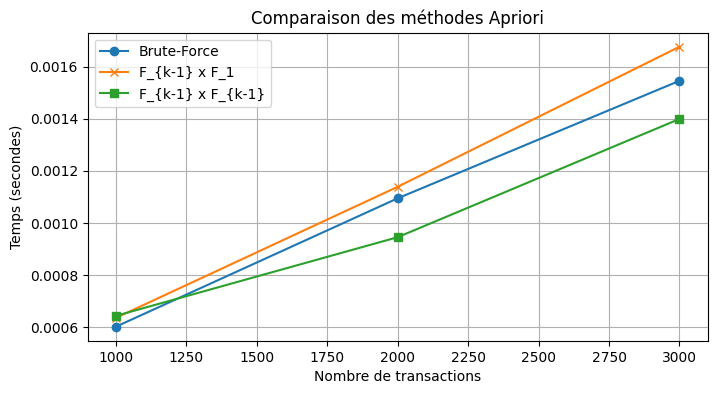

In [21]:
experiment_benchmark(50, [10, 30], nb_repetition=500, min_sup_arbitrary=0.3)


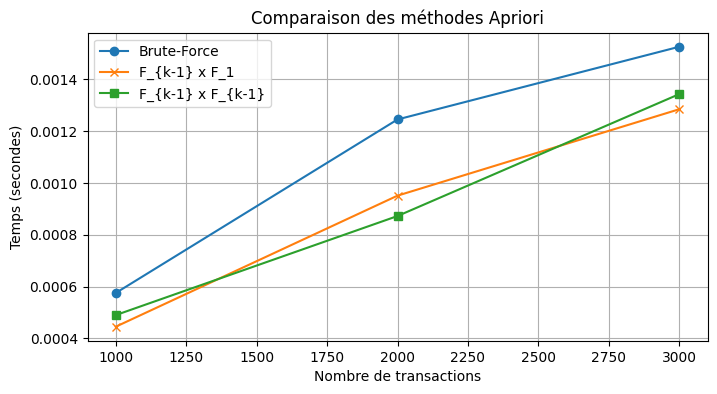

In [266]:
experiment_benchmark(50, [10, 30], nb_repetition=100, min_sup_arbitrary=0.01)


# III. Comparaison avec les implémentations de MLxtend et Spark MLlib

## Utilisation de Mlxtend sur le dataset Bread, Milk, Beer, Eggs, Diapers, Coke

In [3]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

dataset = [
    ["Bread", "Milk"],
    ["Bread", "Diapers", "Beer", "Eggs"],
    ["Milk", "Diapers", "Beer", "Coke"],
    ["Bread", "Milk", "Diapers", "Beer"],
    ["Bread", "Milk", "Diapers", "Coke"]
]
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
apriori(df, min_support=0.6, use_colnames=True)

,support,itemsets
0,0.6,(Beer)
1,0.8,(Bread)
2,0.8,(Diapers)
3,0.8,(Milk)
4,0.6,"(Diapers, Beer)"
5,0.6,"(Bread, Diapers)"
6,0.6,"(Bread, Milk)"
7,0.6,"(Diapers, Milk)"


Ces résultats sont équivalents à ceux obtenus avec notre implémentation de l'algorithme Apriori. Par exemple, 0.6 pour la première ligne s'interprète comme 60% de présence dans le dataset pour l'item Beer (qui est présent dans 3 transactions sur 5), ce qui correspond à notre première itération d'algorithme, en effet en étant inclus dans les items fréquents avec un minsup à 0.6, on ne selectionne que ceux qui ont 60% ou plus de présence dans le dataset.

## Utilisation de Spark sur le dataset Bread, Milk, Beer, Eggs, Diapers, Coke


In [ ]:
import pyspark
from pyspark.sql.session import SparkSession

sc = pyspark.SparkContext()
sc.setLogLevel("ERROR")
spark = SparkSession(sc)


In [10]:
from pyspark.ml.fpm import FPGrowth

df = spark.createDataFrame([
    (0, ["Bread", "Milk"]),
    (1, ["Bread", "Diapers", "Beer", "Eggs"]),
    (2, ["Milk", "Diapers", "Beer", "Coke"]),
    (3, ["Bread", "Milk", "Diapers", "Beer"]),
    (4, ["Bread", "Milk", "Diapers", "Coke"])
], ["id", "items"])

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.6, minConfidence=0.6)
model = fpGrowth.fit(df)

model.freqItemsets.show()



+----------------+----+
|           items|freq|
+----------------+----+
|       [Diapers]|   4|
|         [Bread]|   4|
|[Bread, Diapers]|   3|
|          [Milk]|   4|
|   [Milk, Bread]|   3|
| [Milk, Diapers]|   3|
|          [Beer]|   3|
| [Beer, Diapers]|   3|
+----------------+----+



Les résultats obtenus avec Spark sont également cohérents avec les précédents. Par exemple, l'item Beer est présent dans 3 transactions sur 5, ce qui correspond à un support de 0.6, et il est inclus dans les itemsets fréquents avec un support de 0.6.

In [ ]:

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from pyspark.ml.fpm import FPGrowth


def experiment_benchmark2(nbItems, intervalle, nb_repetition, min_sup_arbitrary):
    transactions_sizes = [1000, 2000, 3000]
    times_mxltend = []
    times_spark = []
    times_fkm1fk1 = []
    
    experiments = []
    
    for _ in range(nb_repetition):
        for size in transactions_sizes:
            generateTransaction = Apriori.generateTransaction(size, nbItems, intervalle)
            generateTransactionForSpark = [(i,transaction) for i, transaction in enumerate(generateTransaction)]            
            # print(generateTransactionForSpark)
            # Test F_{k-1} x F_{k-1}
            start = time.time()
            Apriori(generateTransaction, min_sup_arbitrary, method=3, verbose=False)
            end = time.time()
            times_fkm1fk1.append(end - start)
            
             # Test spark
            start = time.time()
            fpGrowth = FPGrowth(itemsCol="items", minSupport=min_sup_arbitrary, minConfidence=min_sup_arbitrary)
            df = spark.createDataFrame(
                generateTransactionForSpark,["id", "items"])
            fpGrowth.fit(df)
            end = time.time()
            times_spark.append(end - start)
            
             # Test mxltend
            start = time.time()
            te = TransactionEncoder()
            te_ary = te.fit(generateTransaction).transform(generateTransaction)
            df = pd.DataFrame(te_ary, columns=te.columns_)
            apriori(df, min_support=min_sup_arbitrary, use_colnames=True)
            end = time.time()
            times_mxltend.append(end - start)
            
            
            
        experiments.append((times_mxltend, times_spark, times_fkm1fk1))
    
    
    times_mxltend  = [sum(experiments[i][0][k] for i in range(nb_repetition))/nb_repetition for k in range(len(transactions_sizes))]
    times_spark = [sum(experiments[i][1][k] for i in range(nb_repetition))/nb_repetition for k in range(len(transactions_sizes))]
    times_fkm1fk1 = [sum(experiments[i][2][k] for i in range(nb_repetition))/nb_repetition for k in range(len(transactions_sizes))]


    Apriori.plot_comparison2(transactions_sizes, times_fkm1fk1, times_spark, times_mxltend)


## Benchmark des performances de Spark, Mlxtend et F_{k-1} x F_{k-1}
Surprenamment, nos résultats sont relativement proche, ou alors notre algorithme est plus performant. Nous expliquons cela par l'utilisation de problèmes peu complexe qui sont rapidement résolu par notre algorithme, alors que des problèmes plus complexe pourraient montrer des différences plus significatives.

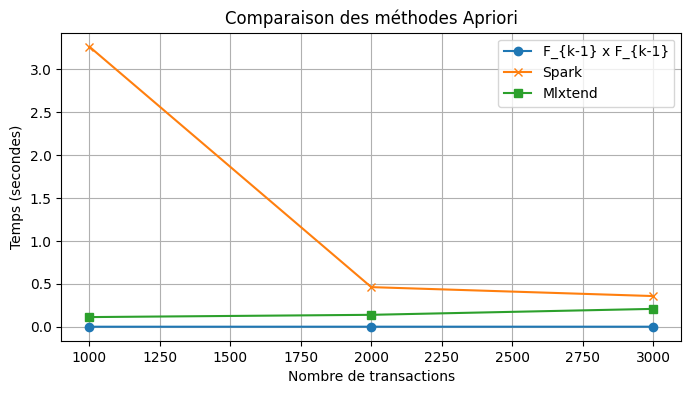

In [7]:
experiment_benchmark2(20, [10,15], nb_repetition=5, min_sup_arbitrary=0.1)
